# Variational Quantum Linear Solver
This tutorial aims to implement the Variational Quantum Linear Solver(VQLS) algorithm proposed by [Carlos Bravo-Prieto et al](https://arxiv.org/pdf/1909.05820).

![VQLS Diagram](figures/VQLS_Diagram.png)

The algorithm takes as input a matrix A written as a linear combination of unitaries A<sub>L</sub> and a short-depth quantum circuit U which prepares the state |b⟩, and produces a quantum state |x⟩ that is approximately proportional to the solution of the linear system Ax= b.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim

from qibo import (
    Circuit,
    gates,
    set_backend,
)

from qiboml.models.decoding import VariationalQuantumLinearSolver
from qiboml.interfaces.pytorch import QuantumModel

## Define Hyperparameters
Setting backend to "pytorch" enables automatic differentiation of quantum circuits using PyTorch. This allows us to use the ADAM optimizer when optimizing the circuit parameters.

In [2]:
# Set backend
set_backend("qiboml", platform="pytorch")

# Hyper-parameters
n_qubits = 3
q_delta  = 0.001
rng_seed = 42
np.random.seed(rng_seed)
weights = q_delta * np.random.randn(n_qubits)

[Qibo 0.2.19|INFO|2025-07-09 09:46:35]: Using qiboml (pytorch) backend on cpu


## Representing our Matrix(A) and Target Vector(b)
Matrix A must be represented as a linear combination of unitaries A<sub>L</sub>

In [ ]:
circuit = np.array([1.0, 0.2, 0.2]) # Coefficients of the linear combination A = c_0 A_0 + c_1 A_1 ...

Id = np.identity(2)
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])

A_0 = np.identity(8)
A_1 = np.kron(np.kron(X, Z), Id)
A_2 = np.kron(np.kron(X, Id), Id)

# Linear combination A = c₀A₀ + c₁A₁ + c₂A₂
A_num = circuit[0] * A_0 + circuit[1] * A_1 + circuit[2] * A_2

# Target Vector
b = np.ones(8) / np.sqrt(8)

## Initialize Variational Circuit
 Variational circuit mapping the ground state $|0\rangle$ to the ansatz state $|x\rangle$

In [4]:
def variational_block(weights):
    variational_ansatz = Circuit(n_qubits)
    for idx in range(n_qubits):
        variational_ansatz.add(gates.H(idx))
    for idx, element in enumerate(weights):
        variational_ansatz.add(gates.RY(idx,element))
    return variational_ansatz

## Building Custom Decoder
 The parameters should be optimized in order to maximize the overlap between the quantum states $|\Psi\rangle$ and $|b\rangle$. To acheive this we define the cost function

$$
C_G = 1 - |\langle b | \Psi \rangle|^2
$$

which quantifies the infidelity between our two states. When $$|\langle b | \Psi \rangle|^2 = 1 \quad \text{(perfect overlap)}, \quad C_G = 0.$$

Using the VariationalQuantumLinearSolver class from the QiboML library we are able to generate our desired cost from the output of our variational circuit.

In [5]:
decoder = VariationalQuantumLinearSolver(n_qubits, target_state=b, A = A_num)

## Build Model
Use QiboML's QuantumModel class to build the machine learning model.

In [6]:
# Prepare the test circuit and decoder
circuit = variational_block(weights)

# Build Model
model = QuantumModel(
    decoding=decoder,
    circuit_structure=circuit)

## Train Circuit
Use the ADAM optimizer to perform gradient descent on loss landscape and optimize circuit parameters.

In [7]:
optimizer = optim.Adam(model.parameters(), lr=0.05)

# Optimize
for iteration in range(300):
    optimizer.zero_grad()
    cost = model()
    cost.backward()
    optimizer.step()

    if iteration % 20 == 0:
        print(f"Iteration {iteration}: Cost = {cost.item():.6f}")

Iteration 0: Cost = 0.027048
Iteration 20: Cost = 0.000190
Iteration 40: Cost = 0.000196
Iteration 60: Cost = 0.000003
Iteration 80: Cost = 0.000004
Iteration 100: Cost = 0.000001
Iteration 120: Cost = 0.000000
Iteration 140: Cost = 0.000000
Iteration 160: Cost = 0.000000
Iteration 180: Cost = 0.000000
Iteration 200: Cost = 0.000000
Iteration 220: Cost = 0.000000
Iteration 240: Cost = 0.000000
Iteration 260: Cost = 0.000000
Iteration 280: Cost = 0.000000


## Final Parameters and Results

In [8]:
optimized_params = model.circuit_parameters.detach().cpu().numpy()
print("Optimized theta values: ", optimized_params)
param_circuit = variational_block(optimized_params)
result = param_circuit.execute()
final_state = result.state().detach().numpy()
print("Final state vector (as amplitudes):")
print(final_state)

Optimized theta values:  [-5.42217344e-09  3.30297394e-01 -8.53152139e-09]
Final state vector (as amplitudes):
[0.29061909+0.j 0.29061909+0.j 0.40686674+0.j 0.40686674+0.j
 0.29061909+0.j 0.29061909+0.j 0.40686674+0.j 0.40686674+0.j]


## Comparison with Classical Solution

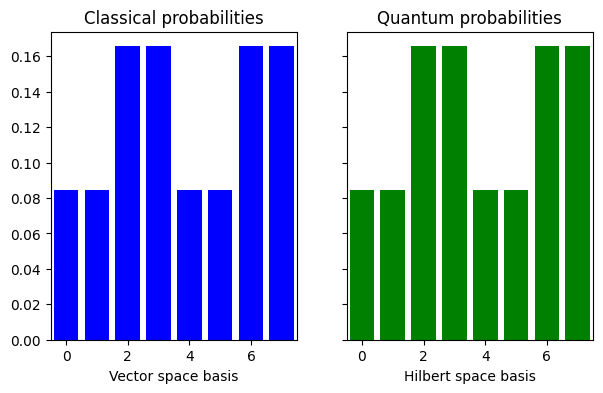

In [9]:
q_probs = np.abs(final_state)**2

A_inv = np.linalg.inv(A_num)
x = np.dot(A_inv, b)

c_probs = (x / np.linalg.norm(x)) ** 2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4), sharey=True)

ax1.bar(np.arange(0, 2 ** n_qubits), c_probs, color="blue")
ax1.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical probabilities")

ax2.bar(np.arange(0, 2 ** n_qubits), q_probs, color="green")
ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")

plt.show()